
# Introduction

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this project you will leverage skills that you have learnt in the past few weeks, such as Topic Modeling, Latent Dirichlet Allocation to build a small model analyzing the content of news articles from different sources around the US.

The main learning objectives for this assignment are:
1. Use LDA topic modeling to find patterns in a realistic, noisy, unlabeled text corpus
2. Understand how topic modeling results are influenced by preprocessing and hyperparemters 
3. Use dimensionality reduction and clustering algorithms to create effective visualizations of large text data 

# Installation and Imports

In [2]:
# Python Import Statements 
import re
import collections
import sys
import math
import numpy as np
import csv
import spacy

# Part 1: Basic Topic Model

First, let's train a basic topic model and see what happens! We'll do very basic text preprocessing (tokenization and lower casing) to start, and we'll use LSA for the topic model.

You can download the dataset [here](https://drive.google.com/file/d/1146a1rhJ95NEySuMS000KDRPcat-itPh/view?usp=sharing) - we've handled loading it below. 

**Warning**: Loading the data could take as much as 10 minutes when running for the first time. After that, the parsed documents are cached in a pickle file...

In [3]:
# TODO: build the following:
# 1. M: a binary term-document matrix
# 2. word2idx: a word2idx dictionary which maps each word to its rank in the vocabular (e.g.
#    the most frequent word should have rank 0, the second most frequent word rank
#    1, etc) 
# 3. idx2word: the inverse of the above (i.e., mapping from index to word)
#
# You will use M to train the topic model directly, and you will use the other two
# lookup tables in order to analyze the actual topics produced. You should use
# spacy to tokenize and lowercase the raw text, but not do any additional preprocessing.

In [3]:
# took 8:15 to process 5000
cutoff = 5000 #use this variable if you want to debug with less data
nlp = spacy.load('en_core_web_sm')

from tqdm import tqdm

location = []
spacy_processed = []

FILEPATH = ""

from os.path import exists
import pickle

if exists("spacy_processed_docs.pkl"):
  with open("spacy_processed_docs.pkl", 'rb') as f:
    spacy_processed, location = pickle.load(f)
    f.close()
else:
  with open(FILEPATH+'articles_sampled_data.csv', 'r', encoding='utf-8') as f:
    for i, row in tqdm(enumerate(csv.DictReader(f, delimiter=','))):
      if i == cutoff:
        break
      if i % 500 == 0:
        print("Processing row %d"%i)
      try: 
        parsed = nlp(row["content"])
        source_name = row["location"]
      except ValueError:
        continue
      spacy_processed.append(parsed)
      location.append(source_name)
    f.close()
  
  with open("spacy_processed_docs.pkl", 'wb') as f:
    pickle.dump((spacy_processed, location), f)
    f.close()

2it [00:00,  9.68it/s]

Processing row 0


500it [00:54,  5.64it/s]

Processing row 500


1001it [01:43, 10.77it/s]

Processing row 1000


1502it [02:31, 12.82it/s]

Processing row 1500


2000it [03:18, 14.98it/s]

Processing row 2000


2502it [04:02, 11.32it/s]

Processing row 2500


3001it [04:45, 15.54it/s]

Processing row 3000


3502it [05:33, 13.16it/s]

Processing row 3500


4002it [06:14, 13.04it/s]

Processing row 4000


4501it [07:00,  7.69it/s]

Processing row 4500


5000it [07:49, 10.66it/s]


In [6]:
print("PROCESSED")
print(spacy_processed[0])
print(f"\nNumber of documents: {len(spacy_processed)}")

PROCESSED
By Special to the Advance

Spain Park’s Sarah Ashlee Barker is the Alabama Sports Writers Association 33rd Miss Basketball and first from Spain Park.

The Georgia signee is also the Gatorade state Player of the Year, the MaxPreps state Player of the Year, the AL.com Player of the Year and the AL.com Birmingham Region Player of the Year.

She has been selected to the Alabama Sports Writers Association All-State team each of the past three seasons and is the two-time Class 7A Player of the Year.

Barker led the Jaguars to their second Class 7A state championship in the past three seasons, averaging 23.3 points, 10.9 rebounds and 2.7 assists this season for coach Mike Chase.

She earned Class 7A tournament MVP this season and was also named all-tournament on Spain Park’s 2018 championship team and 2017 finalist squad.

Number of documents: 5000


In [4]:
from gensim.corpora import Dictionary
import collections
from sklearn.feature_extraction.text import CountVectorizer

# TODO: build the following:
# 1. M: a binary term-document matrix. (Num documents, |vocab|) matrix
# 2. word2idx: a word2idx dictionary which maps each word to its rank in the vocabular (e.g.
#    the most frequent word should have rank 0, the second most frequent word rank
#    1, etc) 
# 3. idx2word: the inverse of the above (i.e., mapping from index to word)
#
# You will use M to train the topic model directly, and you will use the other two
# lookup tables in order to analyze the actual topics produced. You should use
# spacy to tokenize and lowercase the raw text, but not do any additional preprocessing.



def binary_term_doc_matrix(docs):
  #docs: a list of spacy processed documents (i.e. each item is the output of nlp(article))

  # lower case the spacy token
  l_docs=[[tk.text.lower() for tk in sentence] for sentence in docs]
  test_docs=[' '.join(words) for words in l_docs]
  vectorizer = CountVectorizer()
  M = vectorizer.fit_transform(test_docs)
  
  # create vocabulary for corpus tokens
  vocab=vectorizer.get_feature_names()
  Idx=range(1, len(vocab))

  word2idx = dict(zip(vocab, Idx))
  idx2word = dict(zip(Idx, vocab))

  word2idx['PAD'] = 0
  idx2word[0] = 'PAD'

  #TODO: fill in word2idx and idx2word
  #every value in M is 0 or 1
  M = np.zeros((len(docs), len(vocab)))
  #TODO: fill in M
  M = vectorizer.fit_transform(test_docs)


  return M, idx2word


In [5]:
###############################################
#Run the function you just wrote.
M,idx2word= binary_term_doc_matrix(spacy_processed)
print(M.shape)
###############################################

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(5000, 61183)


In [6]:
# TODO: Train a 10-topic topic model on M using Latent Dirichlet Allocation
from sklearn.decomposition import LatentDirichletAllocation

def train_topic_model(term_doc_mat, n_topics=10):
  #TODO use LDA to fit a model with n_topics, return the model
  lda = LatentDirichletAllocation(n_components=n_topics, random_state=42).fit(term_doc_mat)

  return lda

In [56]:
# TODO: Print out (and return) the top 10 words associated with each topic
# Hint: you will need to use or idx2word map. You will also
# likely find numpy's argsort to be helpful here
# Make sure you check the sklearn documentation to get each topic from the model
def print_topics(topic_model, idx2word):
    wd_values=list(idx2word.values())
    topics=[]
    for topic_idx, topic in (enumerate(topic_model.components_)):
      print ("Topic %d:" % (topic_idx))
      ind = np.argpartition(topic, -10)[-10:]
      words = [wd_values[i] for i in ind]
      print(words)
      topics.append(words)

    return topics


In [8]:
###############################################
# now run it and let's look at the output!
topic_model = train_topic_model(M, n_topics=10)

print_topics(topic_model, idx2word)
#1m29 to run
###############################################

Topic 0:
['will', 'county', 'on', 'in', 'to', 'at', 'for', 'of', 'and', 'the']
Topic 1:
['have', 'for', 'is', 'said', 'that', 'in', 'and', 'of', 'to', 'the']
Topic 2:
['season', 'game', 'on', 'to', 'the', 'and', 'of', 'for', 'with', 'in']
Topic 3:
['his', 'to', 'at', 'in', 'of', 'she', 'her', 'was', 'and', 'the']
Topic 4:
['said', 'are', 'will', 'of', 'for', 'the', 'is', 'to', 'in', 'and']
Topic 5:
['on', 'is', 'said', 'in', 'that', 'for', 'and', 'the', 'to', 'of']
Topic 6:
['you', 'for', 'of', 'it', 'is', 'the', 'in', 'to', 'and', 'that']
Topic 7:
['15', '11', 'quad', '12', '10', 'argus', 'dispatch', '30', 'from', '00']
Topic 8:
['at', 'his', 'he', 'was', 'on', 'to', 'the', 'in', 'and', 'of']
Topic 9:
['skin', 'is', 'the', 'your', 'suicide', 'hair', 'her', 'of', 'and', 'in']


# Part 2: Improved Topic Model

Now let's try to improve the quality of the topics by improving the features our model can use (as opposed to binary features). 

**(1)** First, we'll write a helper function to preprocess a spacy document. This is similar to what you did in project 1. Here, we only want you to **lowercase, remove newlines** (token.pos_=='SPACE'), **remove puncuation, and remove stopwords**.


**(2)** Then, you will implement tf-idf:
tf-idf is the product of two statistics: 

**Term Frequency (tf)**: 

the relative frequency of a term $w$ in a document $d$.
We will use the following formula:
  
tf $= 0.5+(0.5*\frac{f_w}{max\{f_w':\ w'\ \in\ d\}})$

where $f_w$ is the frequency $w$ in document $d$. For each document, each word in that document has a tf value.


**Inverse Document Frequency (idf)**: 

For the whole corpus of documents $D$, how many of the documents does the term $w$ appear? Intuitively, this is how much information a word provides if it appears in a document.
We will use the following formula:

idf $= log(\frac{|D|}{|d\ \in D: w\ \in d|})$

where the denominator indicates the number of documents that a term $w$ appears in. Note that there is one idf value for each word in the vocab. Hint: You will have to iterate over all of the documents to calculate idf prior to remaking your matrix M

finally, the tf-idf score is calculated by multiplying these two values together:


# =**tf*idf**

In [39]:
# TODO: Reconstruct M, word2idx, and idx2word.
# This time, let's make the following changes:
# 1. Filter out stopwords and punctuation (using spacy)
# 2. Filter the vocabulary to only the most frequent 5K words
# 3. Use tf-idf values instead of binary count to remake M

# Hint: although it's a little less efficient, it might be easier to iterate
# through the list of documents multiple times

from collections import Counter # you may find this useful
import math
import itertools

def preprocess_doc(doc):
  # First, write a helper function that takes a spacy processed doc,
  # filter out stopwords and punctuation, then returns a
  # a list of preprocessed strings
  proc_doc = []
  stopwords = nlp.Defaults.stop_words


  # remove stopwords and lowercase
  for token in doc:
    if token.text.lower() not in stopwords :
      # remove puncutation
       if not token.is_punct:
         # remove newline
          if token.pos_ != 'SPACE':
            proc_doc.append(token.text.lower())
  
  return proc_doc
  

# help function 2 calculate the tf values
def count_dict(sentences, vocab):
    count_dict = {}
    for word in vocab:
        count_dict[word] = 0
    for sent in sentences:
        for word in set(sent):
            count_dict[word] += 1
    return count_dict

# help function 3 calculate the tf/idf values
def term_frequency(document, word):
    N = len(document)
    occ = len([token for token in document if token == word])
    tf= 0.5+0.5*(occ / N)
    return tf

def inverse_document_frequency(word, doc_dict):
    try:
        word_occurance = doc_dict[word] + 1
    except:
        word_occurance = 1
    return np.log(5000 / word_occurance)

# help function 4 calculate the tf/idf values
def tf_idf(sentence, vocab):
    vec = np.zeros((len(vocab),))
    for word in sentence:
        tf = term_frequency(sentence, word)
        idf = inverse_document_frequency(word,vocab)
        vec[word_index[word]] = tf * idf
    return vec


def tfidf_term_doc_matrix(docs, vocab_cutoff=5000):
  #docs is a list of spacy processed documents.
  #There are multiple steps in this function: 
  #Creating the vocab, thresholding it by vocab_cutoff, computing idf,
  #computing tf for each word in each document, and setting the correct value of
  #M to that value. 
  proc_docs = [preprocess_doc(txt) for txt in docs] # a list of lists of preprocessed docs

  wd_bank = list(itertools.chain.from_iterable(res))
  word_counter = collections.Counter()
  for term in wd_bank:
        word_counter.update({term: 1})
  cm_vocab = word_counter.most_common(vocab_cutoff)
  cm_wd_lst=[ele[0] for ele in cm_vocab]

  # use just first top "cutoff" words
  freq_tt=[]
  for doc in proc_docs:
      temp=[]
      for ele in doc:
        if ele in cm_wd_lst:
          temp.append(ele)
        else:
          pass;
      freq_tt.append(temp)
  
  Idx = range(len(cm_wd_lst))
  word2idx = dict(zip(cm_wd_lst, Idx))
  idx2word = dict(zip(Idx, cm_wd_lst))

  # calculate the tf-idf matrix

  M = []

  wd_doc_dict=count_dict(freq_tt, cm_wd_lst)
  for sent in freq_tt:
    M.append(tf_idf(sent, wd_doc_dict))
  

  #Do not modify the return statement
  return M, idx2word
  

In [40]:
#################################################
# Now try see what happens when you train a topic
# model with preprocessed text and tfidf features!

M, idx2word = tfidf_term_doc_matrix(spacy_processed)

topic_model = train_topic_model(M, n_topics=10)
print_topics(topic_model, idx2word)

#################################################

Topic 0:
['virtual', 'p.m.', 'community', 'school', 'student', 'events', 'event', 'program', 'students', 'education']
Topic 1:
['subscriber', 'site', 'customer', 'service', 'premium', 'login', 'access', 'subscription', 'click', 'content']
Topic 2:
['sister', 'brother', 'cemetery', 'daughter', 'grandchildren', 'church', 'wife', 'survived', 'funeral', 'born']
Topic 3:
['player', 'league', 'season', 'team', 'game', 'coach', 'win', 'players', 'games', 'play']
Topic 4:
['world', 'weather', 'rain', 'old', 'red', 'tv', 'national', 'inches', 'feet', 'snow']
Topic 5:
['approved', 'funding', 'million', 'money', 'funds', 'meeting', 'tax', 'revenue', 'council', '$']
Topic 6:
['vote', 'senate', 'biden', 'donald', 'democratic', 'trump', 'president', 'republican', 'election', 'political']
Topic 7:
['think', 'thing', 'life', 'way', 'good', 'different', 'like', 'want', 'things', 'know']
Topic 8:
['scene', 'authorities', 'charges', 'sheriff', 'investigation', 'vehicle', 'arrested', 'officers', 'man', 'p

In [ ]:
# Now let's tune the number of topics in order to determine the "right" number
# To do this, we'll choose the number of topics that minimizes perplexity on 
# held-out data. Specifically, you need to do the following:
# 1. Split your data into 80% train and 20% dev
# 2. Using the training data, train 5 topic models, one for each of the following
#    numbers of topics: [1, 5, 10, 15, 20]
# 3. For each trained model, compute the perplexity on the dev set, and plot the result

Training LDA model with 1 topics...
Training LDA model with 5 topics...
Training LDA model with 10 topics...
Training LDA model with 15 topics...
Training LDA model with 20 topics...


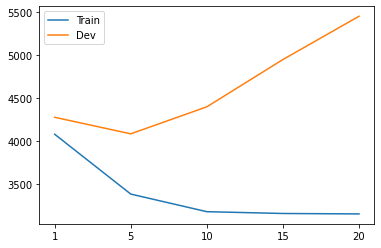

In [41]:
#NOTE: this might take a few mins!
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
ks = [1, 5, 10, 15, 20]

train_data, dev_data = train_test_split(M, test_size=0.2, random_state=42)

train_scores = []
dev_scores = []
for k in ks:
  print("Training LDA model with %d topics..."%k)
  model = train_topic_model(M, n_topics=k)
  train_scores.append(model.perplexity(train_data))
  dev_scores.append(model.perplexity(dev_data))

plt.plot(np.arange(len(train_scores)), train_scores, label="Train")
plt.plot(np.arange(len(dev_scores)), dev_scores, label="Dev")
plt.xticks(np.arange(len(ks)), ['%d'%k for k in ks])
plt.legend()
plt.show()

# Part 3: Visualization

Now, let's use the topic model you just trained to inspect the data visually.

First, we train the model that minimized perplexity above...

In [57]:
# First, let's train a model on the full data using the number of topics you 
# chose above (i.e., the value of k that minimized perplexity on dev).

best_k = 5 # Use the number of clusters that got the best perplexity
topic_model = train_topic_model(M, n_topics=best_k)  # train the topic model with best_k topics
topics = print_topics(topic_model, idx2word)

Topic 0:
['children', 'church', 'life', 'school', 'love', 'born', 'great', 'family', 'parents', 'friends']
Topic 1:
['service', 'local', '$', 'provide', 'use', 'access', 'plan', 'business', 'million', 'businesses']
Topic 2:
['disease', 'deaths', 'health', 'election', 'virus', 'cases', 'republican', 'coronavirus', 'president', 'trump']
Topic 3:
['league', 'played', 'win', 'games', 'play', 'season', 'team', 'players', 'game', 'coach']
Topic 4:
['criminal', 'sheriff', 'investigation', 'charges', 'enforcement', 'attorney', 'police', 'man', 'officers', 'court']



Below, we make use of `sklearn.decomposition.PCA`. With PCA (Principle Component Analysis), we use SVD (Singular Value Decomposition) to do dimensionality reduction of our M matrix. For the purposes of visualization, high-dimensional spaces are difficult to work with, so we'd like to apply PCA to get down to 2 dimensions, which we can easily plot on a graph. 

The output of `PCA.fit_transform()` is a matrix of shape `(n_samples, n_components)`, where `n_samples = #documents`, and `n_components = 2`, in our case. We will treat each row `i` of the output as 2D coordinates for document `i`. Check out the PCA documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). 

In [87]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

# This code defines a PCA model, 
# which we'll use to map the high-dimension topic space to 2D. 
pca = PCA(2) # n_components = 2
proj = pca.fit_transform(M) # returns np.array of (n_samples, n_components)
doc_dists = topic_model.transform(M)


# # TODO: build a dictionary which maps each document in your data to its most
# # prominent topic, according to the topic model.
# # Additionally, we must map the locations of the documents to 
# # Fill out the fields with comments next to them with the appropriate values

plot_data = []

loc_dict = {} # dictionary mapping topics to a list of locations for the documents of that topic
doc_topic = topic_model.transform(M)
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    loc_dict[n]=str(topic_most_pr)

for i, doc in enumerate(spacy_processed):
  d = {} 
  topic = topics[int(loc_dict.get(i))] # get the topic assigned to doc
  d['text'] = spacy_processed[i][:100] # Document raw text, capped at 100 characters 
  d['topic'] = loc_dict.get(i)# Topic number (as a string)
  d['x'] = proj[i][0]# The x coordinate of the projection
  d['y'] = proj[i][1]# The y coordinate of the projection

  plot_data.append(d)
  
  # TODO: Add the location of doc to the appropriate list within loc_dict
  # Remember: location<List<String>>[i] = Location of document i,
  # and loc_dict: dictionary<int, list<string>>
  ...

Now, run the following cell to plot the PCA projection of our documents onto 2D! Each point corresponds to a document, which you can hover over and view some of the contents of!

In [88]:
# This plots the plot_data list built in the previous cell, nothing to do here
df = pd.DataFrame.from_dict(plot_data)
fig = px.scatter(df, x="x", y="y", color="topic")
fig.show()

## Geographical Visualization

Now, we'd like you to visualize the most popular topics based on geographical location! 

We'll start with a simple bar graph showing the popularity of topics by state, where the height of each bar is the proportion of documents from each location that correspond to a particular topic.

As a warning, these counts of documents are unnormalized... Because of this, states that have a lot of documents may more regularly appear at the front of the bar charts. These charts don't indicate which topics are proportionally popular by state, despite it being more intuitive.

In [89]:


from collections import Counter
state_count = {}
for loc in loc_dict:
  temp = dict(sorted(Counter(loc_dict[loc]).items(), key=lambda item: item[1], reverse=True))
  state_count[loc] = (list(temp.keys()),list(temp.values()))

# here, the format of state_count is complicated:
# state_count: dictionary<int, tuple<list<string>, int>>, where each topic (int) is mapped to a pair of lists,
# where state_count[t][1][i] is the count of documents in topic t, corresponding to the state at state_count[t][0][i]

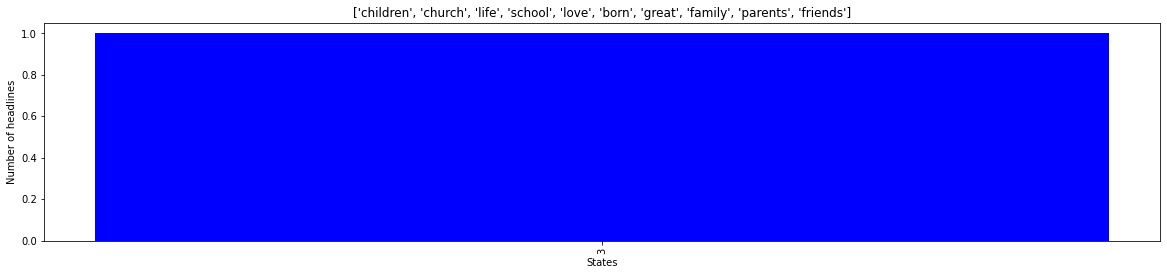

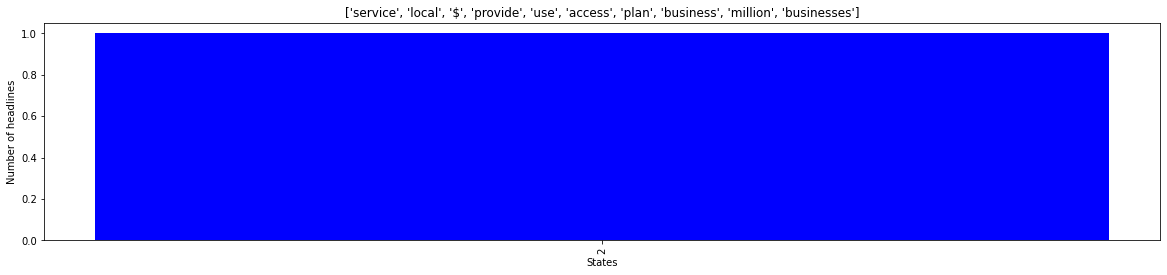

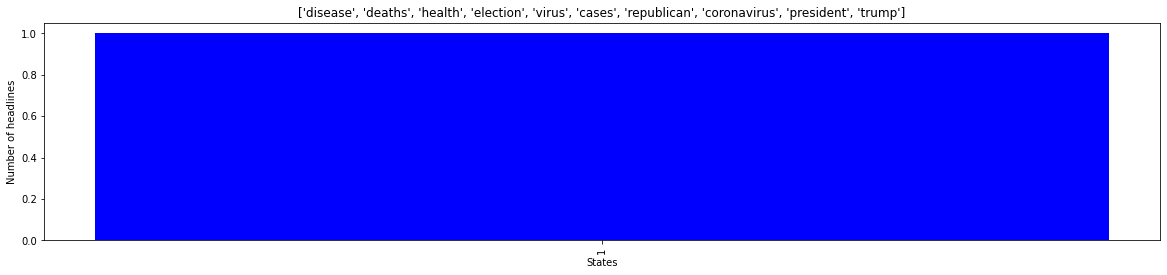

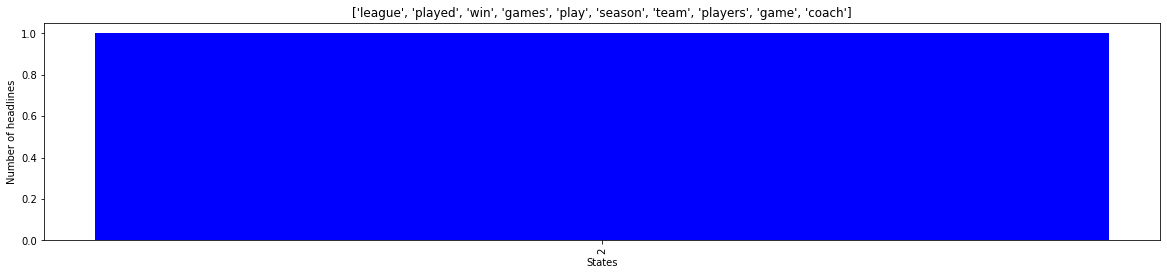

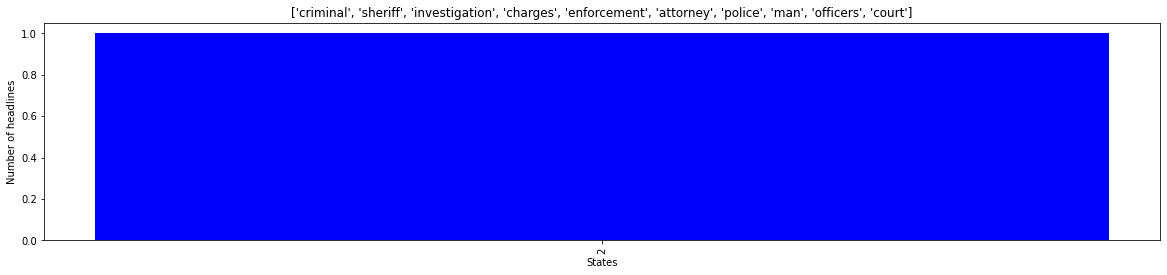

In [90]:
# this code makes a bar graph displaying the popularity (as a proportion) per state...
for k in range(best_k):
  fig = plt.figure(figsize=(20,4))
  state_names = state_count[k][0]
  count = np.array(state_count[k][1])
  
  plt.bar(state_names, count, color ='blue', width = .8)
  plt.xticks(rotation=90)
  plt.xlabel("States")
  plt.ylabel("Number of headlines")
  plt.title(topics[k])
  plt.show()

Now, we'll use a library to plot the number of documents of each topic on a map, because it's much more visually intuitive than a bar graph!

In [ ]:
from geopy.geocoders import Nominatim
import plotly.graph_objects as go

# our geolocation service
geolocator = Nominatim(user_agent='myapplication')
for k in range(best_k):
  lon, lat = [], []
  state_names = state_count[k][0]
  count = np.array(state_count[k][1])
  labels = []
  # assign each state a geographical location
  for state, c in zip(state_names, count):
    location = geolocator.geocode(state)
    lat.append(location.latitude)
    lon.append(location.longitude)
    labels.append(state + " : " + str(c) + " headlines")

  marker = dict(color="blue", size=count)
  fig = go.Figure(data=go.Scattergeo(lon=lon, lat=lat, text=labels, mode='markers', marker=marker))
  fig.update_layout(title = topics[k],geo_scope='usa')
  fig.show()

# Submission Instructions
Please submit this Colab as **two** files to Gradescope:
1.   A `.py` file: Click File > Download > Download .py
2.   A `.ipynb` file with outputs: Click Runtime > Run All, and then after all outputs are complete, click File > Download > Download .ipynb

Please ensure that the `.ipynb` contains actual function outputs (and not leftover print statements, for instance). We will run your `.ipynb` file; if our outputs don't match the outputs in your submitted file (within reason), you will receive a 0 on this assignment.